<a href="https://colab.research.google.com/github/CamAndrade/darkCovidNetReproduce/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Coleta de dados e Configurações iniciais

Montando o diretório drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Indicando a pasta raiz

In [ ]:
import os
os.chdir('/content/drive/My Drive/datasets')

Clonando o repositório do dataset

In [ ]:
!git clone https://github.com/muhammedtalo/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 1234 (delta 27), reused 4 (delta 1), pack-reused 1156
Receiving objects: 100% (1234/1234), 398.58 MiB | 20.09 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Checking out files: 100% (1128/1128), done.


Alterando a pasta raiz para a pasta do dataset clonado

In [ ]:
main_dir = "/content/drive/My Drive/datasets/COVID-19"

Importando as bibliotecas necessárias

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
import torchvision.transforms as transforms
import torch.functional as F

# Carregando os dados em um dataloader


In [ ]:
image_loader = lambda img: Image.open(img).convert('RGB')

In [ ]:
class ToNorm(object):
    def __call__(self,img):
        mean = torch.mean(img)
        std  = torch.std(img)
        return (img - mean)/std

In [ ]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                ToNorm()
                            ])

In [ ]:
dataset = torchvision.datasets.DatasetFolder(main_dir+'/X-Ray Image DataSet',loader = image_loader,extensions='jpg',transform=transform )

In [ ]:
dataset.class_to_idx['Covid-19']

0

In [ ]:
dataLoader = DataLoader(dataset,batch_size=32)

In [ ]:
data,class_att = next(iter(dataLoader))

In [ ]:
grid_img = torchvision.utils.make_grid(data,nrow=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


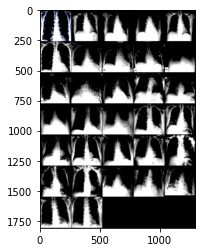

In [ ]:
plt.imshow(grid_img.permute(1,2,0))

# Construção de rede convolucional

In [ ]:
class DarkCovidNet(nn.Module):
  def __init__(self):
    super(DarkCovidNet, self).__init__()
    self.feature = nn.Sequential(
      self.conv_block(3, 8),
      self.maxpooling(),
      self.conv_block(8, 16),
      self.maxpooling(),
      self.triple_conv(16, 32),
      self.maxpooling(),
      self.triple_conv(32, 64),
      self.maxpooling(),
      self.triple_conv(64, 128),
      self.maxpooling(),
      self.triple_conv(128, 256),
      self.conv_block(256, 128, size=1),
      self.conv_block(128, 256),
      self.conv_block(256, 2),
      nn.Flatten()
    )
    self.classifier = nn.Sequential(
      nn.Linear(338, 2)
    )

  def conv_block(self, in_channel, out_channel, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    self.conv_layer = nn.Sequential(
      nn.Conv2d(in_channel, out_channel, kernel_size=size, stride=stride, padding=(for_pad(size) - 1)//2, bias=False), 
      nn.BatchNorm2d(out_channel),
      nn.LeakyReLU(negative_slope=0.1, inplace=True) 
    )
    return self.conv_layer
    
  def triple_conv(self, in_channel, out_channel):
    self.triple_conv_layer = nn.Sequential( 
      self.conv_block(in_channel, out_channel),
      self.conv_block(out_channel, in_channel, size=1),  
      self.conv_block(in_channel, out_channel)
    )
    return self.triple_conv_layer
    
  def maxpooling(self):
    return nn.MaxPool2d(2, stride=2)

  def forward(self,x):
    x = self.feature(x)
    x = self.classifier(x)
    return x

In [ ]:
model = DarkCovidNet()

In [ ]:
import torchsummary

In [ ]:
torchsummary.summary(model,(3,256,256),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             216
       BatchNorm2d-2          [-1, 8, 256, 256]              16
         LeakyReLU-3          [-1, 8, 256, 256]               0
         MaxPool2d-4          [-1, 8, 128, 128]               0
            Conv2d-5         [-1, 16, 128, 128]           1,152
       BatchNorm2d-6         [-1, 16, 128, 128]              32
         LeakyReLU-7         [-1, 16, 128, 128]               0
         MaxPool2d-8           [-1, 16, 64, 64]               0
            Conv2d-9           [-1, 32, 64, 64]           4,608
      BatchNorm2d-10           [-1, 32, 64, 64]              64
        LeakyReLU-11           [-1, 32, 64, 64]               0
           Conv2d-12           [-1, 16, 66, 66]             512
      BatchNorm2d-13           [-1, 16, 66, 66]              32
        LeakyReLU-14           [-1, 16,